In [14]:
import sys
mmseg_rt = '/home/dejuns/git/mmseg4med'
monai_rt = '/home/dejuns/git/MONAI'
if mmseg_rt in sys.path: sys.path.remove(mmseg_rt)
if monai_rt in sys.path: sys.path.remove(monai_rt)

import torch
import torch.nn.functional as F
import numpy as np 

from mmdet.utils.this_utils import  run_parralel
from mmdet.datasets.transform4med.io4med import (
        os, IO4Nii, osp, Path, save_string_list)

import ipdb
from skimage.morphology import binary_opening, disk
import cc3d
import pandas as pd

from demo.visual_gt_pred import  plotNImage, save_fig


def largest_region_index(mask_multi):
    non_zero_arr = mask_multi[mask_multi > 0].flatten()
    if non_zero_arr.size == 0: return 0
    mask_max_index = np.argmax(np.bincount(non_zero_arr))
    return int(mask_max_index)

def find_body_extend(img_3d, verb = False):

    x, y, z = img_3d.shape
    axial_proj_2d = img_3d.sum(axis = -1)
    hu_max, hu_min = np.max(axial_proj_2d), np.min(axial_proj_2d)
    hu_mean, hu_std = np.mean(axial_proj_2d), np.std(axial_proj_2d)
    thresh = hu_mean + 0.55 * hu_std
    # axial_proj_2d = (axial_proj_2d - hu_mean) / hu_std
    # thresh = threshold_otsu(axial_proj_2d)
    if verb: print(f'[axial_proj] min{hu_min:.4f} max{hu_max:.4f} mean{hu_mean:.4f} std{hu_std:.4f} thresh {thresh}')
    down_mask = np.array(axial_proj_2d > thresh, dtype=np.uint8)
    down_mask_open = binary_opening(down_mask, disk(int(7*x/512)))
    down_mask_max, num_region = cc3d.largest_k(down_mask_open, k = 1, connectivity=8, delta=0, return_N=True)

    fg_coords = np.where(down_mask_max.astype(bool))
    x_min, x_max = min(fg_coords[0]), max(fg_coords[0])
    y_min, y_max = min(fg_coords[1]), max(fg_coords[1])
    z_min, z_max = 0, z
    if verb: print(f'\t orisize{img_3d.shape}, bound {x_min} {x_max} {y_min} {y_max}')
    slicer3d = tuple([slice(x_min, x_max), slice(max(0, y_min - 30), min(y, y_max + 10)), slice(z_min, z_max)])
    fg_mask = np.zeros_like(img_3d, dtype = bool)
    fg_mask[slicer3d] = True
    # img_3d[np.logical_not(fg_mask)] =  img_3d.min()
    img_3d_fg = fg_mask * img_3d + (~fg_mask * img_3d.min())
    # y_extend = ((x_max - x_min) - (y_max - y_min)) // 2
    slicer3d = tuple([slice(x_min, x_max), slice(y_min, y_max), slice(z_min, z_max)])
    # body_center = np.array([(x_min + x_max)//2, (y_min + y_max)//2, (z_min + z_max)//2])
    # print('bodycenter', body_center)
    # down_mask_max[body_center[0] - 2 : body_center[0] + 2, body_center[1] - 2 : body_center[1] + 2] = 2
    # axial_crop_region = np.zeros_like(down_mask_max)
    # axial_crop_region[x_min:x_max, y_min:y_max] = 1
    fig = plotNImage([axial_proj_2d, down_mask, down_mask_max, 
            img_3d[(x_min+x_max)//2, ...], img_3d[:, (y_min+y_max)//2,:] ], 
            title_list=['axial_proj', 'axial_mask', 'axial_max', 'saggital', 'coronal'], 
            cmap='gray', is_close= False)

    return img_3d_fg, slicer3d, fig


def respacing_volume(img_3d, target_shape):
    img_3d = torch.from_numpy(img_3d).float()
    # ipdb.set_trace()
    img_5d_new = F.interpolate(img_3d[None, None], 
                                size = target_shape, 
                                mode = 'trilinear', 
                                align_corners= False)
    img_3d_new = img_5d_new[0, 0].int().numpy()
    return img_3d_new


class SpatialCropDJ(object):
    """
    General purpose cropper to produce sub-volume region of interest (ROI).
    It can support to crop ND spatial (channel-first) data.
    Either a spatial center and size must be provided, or alternatively,
    if center and size are not provided, the start and end coordinates of the ROI must be provided.
    """

    def __init__(
        self,
        roi_center, 
        roi_size, 
    ) -> None:
        """
        Args:
            roi_center: voxel coordinates for center of the crop ROI.
            roi_size: size of the crop ROI.
            roi_start: voxel coordinates for start of the crop ROI.
            roi_end: voxel coordinates for end of the crop ROI.
        """

        roi_center = np.array(roi_center, dtype=np.int16)
        roi_size = np.array(roi_size, dtype=np.int16)
        self.roi_start = roi_center - np.floor_divide(roi_size, 2)
        self.roi_end = self.roi_start + roi_size
        self.roi_size = roi_size
       

    def __call__(self, img):
        """
        Apply the transform to `img`, assuming `img` is channel-first and
        slicing doesn't apply to the channel dim.
        """
        # print('img', img.shape)
        image_shape = np.array(img.shape)
        end_xyz_delta = self.roi_end - image_shape
        patch_shape = tuple(self.roi_size)
        patch_image = np.full(patch_shape, img.min(), dtype = img.dtype)
        start_xyz_img = self.roi_start.clip(0) 
        end_xyz_img = self.roi_end.clip(0, image_shape)
        # slice4img = [slice(start_xyz_img[i], end_xyz_img[i]) for i in range(3)]

        start_xyz_patch = np.where(self.roi_start < 0, np.abs(self.roi_start), 0)
        end_xyz_patch = np.where(end_xyz_delta > 0, self.roi_size - np.abs(end_xyz_delta), self.roi_size) #
        # slice4patch = [slice(start_xyz_patch[i], end_xyz_patch[i]) for i in range(3)]

        sd = min(len(self.roi_start), len(self.roi_end), len(img.shape))  # spatial dims
        slices4img = tuple([slice(s, e) for s, e in zip(start_xyz_img[:sd], end_xyz_img[:sd])])
        slices4patch = tuple([slice(s, e) for s, e in zip(start_xyz_patch[:sd], end_xyz_patch[:sd])])

        patch_image[slices4patch] = img[slices4img]
        return patch_image, slices4img, slices4patch


def process1volume(pid, origin_path, save_dir, 
                    target_spacing = (1.6, 1.6, 1.6), 
                    target_shape_raw = (224, 224, None), save_suffix = ''):
    """
    from load to process to save
    """
    img_3d_origin, affine_matrix = IO4Nii.read(origin_path, verbose = False, dtype = np.int16)
    img_ori_size = img_3d_origin.shape
    old_spacing = [abs(affine_matrix[i, i]) for i in range(3)]
    new_shape_raw = [int(img_ori_size[i] * old_spacing[i] / target_spacing[i]) for i in range(3)]

    # 1. resize to target spacing
    img_ori_resize = respacing_volume(img_3d_origin, new_shape_raw)
    img_shrink_size = img_ori_resize.shape

    target_shape = [a for a in target_shape_raw]
    for i, ts in enumerate(target_shape_raw): 
        if ts is None: target_shape[i] = new_shape_raw[i]

    print(f'\t orisize {img_ori_size} respacing {img_shrink_size} target {target_shape}')
    # 2. find body center and perform center crop to target size
    img_3d_fg, body_slicer, proj_fig = find_body_extend(img_ori_resize)
    body_center = [(body_slicer[i].start + body_slicer[i].stop)//2  for i in range(3)]
    center_cropper = SpatialCropDJ(body_center, target_shape)
    img_3d_body, slices4img, slices4patch = center_cropper(img_3d_fg)
    print(f'BodyCenter{body_center} target shape {target_shape}')

    # 3. write body image to disk
    affine_new = affine_matrix.copy()
    for i in range(3): affine_new[i, i]  = np.sign(affine_matrix[i, i]) * target_spacing[i]
    
    store_file = f'{pid}_{save_suffix}'
    new_img_path = IO4Nii.write(img_3d_body.astype(np.int16), save_dir, store_file, affine_new)

    save_fig(proj_fig, osp.join(save_dir, f'{store_file}.png'))

    case_info = {'pid': pid, 'old_shape': img_ori_size, 'old_spacing': old_spacing, 
                'resize_shape': img_shrink_size, 
                'new_shape': img_3d_body.shape, 'new_spacing': target_spacing, 
                'img_path' : new_img_path, 'body_center': body_center}
    # new_img_path = store_file
    return case_info


def process_loop(img_paths, store_dir, 
                target_spacing = (1.6, 1.6, 1.6), 
                target_shape = (256, 256, None), save_suffix = '', prcs_ix = 99):
    
    case_info_list = []
    for i, img_path in enumerate(img_paths):
        pid = img_path.split(os.sep)[-1].split('.nii.')[0]
        if i % 5 == 0: print(f'[Worker{prcs_ix}] {i} {pid} {img_path}')
        case_info = process1volume(pid, img_path, store_dir, target_spacing, target_shape, save_suffix)
        case_info_list.append(case_info)

    return case_info_list

[Worker99] 0 case_00330_0000 /data/lung_algorithm/data/sw_project/lung/MONAI/raw/imagesAll_0404/case_00330_0000.nii.gz
	 orisize (512, 512, 280) respacing (225, 225, 218) target [256, 256, 218]


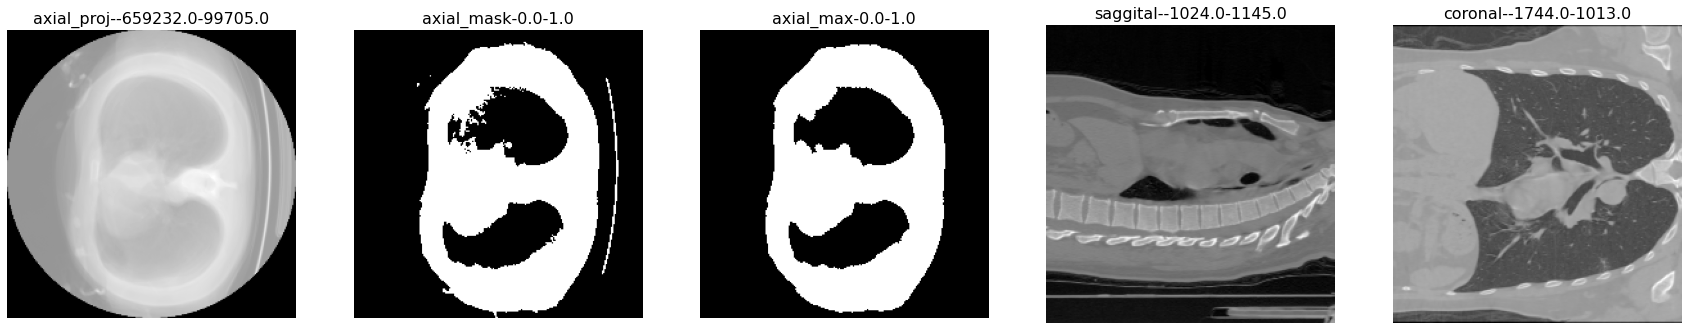

BodyCenter[116, 120, 109] target shape [256, 256, 218]


In [15]:

imgdir2store = {'/data/lung_algorithm/data/sw_project/lung/MONAI/raw/imagesAll_0404' : 'Thoracic_SW', 
                '/data/lung_algorithm/data/lung_nodule/raw/Task110_keya_CT/images': 'Thoracic_Nodule1', 
                '/data/lung_algorithm/data/lung_nodule/raw/Task112_keya_CT/images': 'Thoracic_Nodule1', 
                '/data/lung_algorithm/data/lung_nodule/raw/Task113_keya_CT/images': 'Thoracic_Nodule1', 
                '/data/lung_algorithm/data/lung_nodule/raw/Task114_keya_CT/images': 'Thoracic_Nodule2', 
                '/data/lung_algorithm/data/lung_nodule/raw/Task115_keya_CT/images': 'Thoracic_Nodule2', 
                '/data/lung_algorithm/data/lung_nodule/raw/Task116_keya_CT/images': 'Thoracic_Nodule2', 
                '/data/lung_algorithm/data/lung_nodule/raw/Task210_keya_CT/images': 'Thoracic_Nodule3', 
                '/data/lung_algorithm/data/lung_nodule/raw/Task211_keya_CT/images': 'Thoracic_Nodule3', 
                '/data/lung_algorithm/data/lung_nodule/raw/Task310_keya_CT/images': 'Thoracic_Nodule3', 
                '/data/lung_algorithm/data/LUNA16/raw/imagesTr' : 'Thoracic_LUNA',
                }
store_root = Path('/data/lung_algorithm/data/selfup/processed')

target_spacing = (1.6, 1.6, 1.6)
target_shape = (256, 256, None)
save_suffix = 'body256'
counter = 0
for img_dir, cohort in imgdir2store.items():
    store_rt = store_root/cohort
    store_rt.mkdir(parents=True, exist_ok=True)
    image_paths = [osp.join(img_dir, a) for a in os.listdir(img_dir)]

    cohort_info_list = process_loop(image_paths[:1], 
                                store_rt, 
                                target_spacing, 
                                target_shape, 
                                save_suffix)
    cohort_info_tb = pd.DataFrame(cohort_info_list)
    cohort_info_tb.to_csv(store_rt/f'case_info_{cohort}_{counter}.csv', index = False)
    # save_string_list(store_rt/f'image_list_{cohort}_{counter}.txt', cohort_paths)
    counter += 1
    break